In [ ]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create list of all targets (minus background noise)
dataset_path = '/content/drive/MyDrive/Colab Notebooks/data_speech_commands_v0.02'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['bed', 'backward', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', 'irma']


In [ ]:
# Settings
feature_sets_path = '/content/drive/MyDrive/Colab Notebooks/mfcc_feature_sets'
feature_sets_filename = '/content/drive/MyDrive/Colab Notebooks/mfcc_feature_sets/irma_all_targets_mfcc_sets.npz' #'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_irma_model.h5'
wake_word = 'irma'

In [ ]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [ ]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [ ]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(76380, 16, 16)
(9511, 16, 16)
(9504, 16, 16)


In [ ]:
# Peek at labels
print(y_val)
print(all_targets.index(wake_word))

[21.  8.  0. ...  2. 18. 25.]
35


In [ ]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [ ]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))
print(sum(y_val))

0.0
1.0
0.0


In [ ]:
# View the dimensions of our input data
print(x_train.shape)

(76380, 16, 16)


In [ ]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(76380, 16, 16, 1)
(9511, 16, 16, 1)
(9504, 16, 16, 1)


In [ ]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [ ]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [ ]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [ ]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
764/764 [==============================] - 19s 4ms/step - loss: 0.0194 - acc: 0.9925 - val_loss: 8.5770e-14 - val_acc: 1.0000
Epoch 2/30
764/764 [==============================] - 3s 4ms/step - loss: 4.1112e-04 - acc: 1.0000 - val_loss: 3.6346e-12 - val_acc: 1.0000
Epoch 3/30
764/764 [==============================] - 3s 4ms/step - loss: 6.4444e-04 - acc: 1.0000 - val_loss: 4.4093e-12 - val_acc: 1.0000
Epoch 4/30
764/764 [==============================] - 3s 4ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 3.7927e-11 - val_acc: 1.0000
Epoch 5/30
764/764 [==============================] - 3s 4ms/step - loss: 3.7329e-06 - acc: 1.0000 - val_loss: 2.2267e-11 - val_acc: 1.0000
Epoch 6/30
764/764 [==============================] - 3s 4ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.3396e-12 - val_acc: 1.0000
Epoch 7/30
764/764 [==============================] - 3s 4ms/step - loss: 2.8663e-05 - acc: 1.0000 - val_loss: 1.2177e-10 - val_acc: 1.0000
Epoch 8/30
764/764 [===========

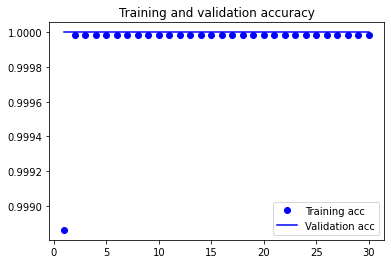

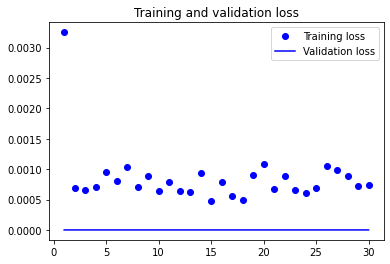

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the model as a file
models.save_model(model, model_filename)

In [ ]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

In [ ]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 22.0  Prediction: [[1.]]
Answer: 9.0  Prediction: [[1.]]
Answer: 29.0  Prediction: [[1.]]
Answer: 27.0  Prediction: [[1.]]
Answer: 29.0  Prediction: [[1.]]
Answer: 17.0  Prediction: [[1.]]
Answer: 21.0  Prediction: [[1.]]
Answer: 16.0  Prediction: [[1.]]
Answer: 26.0  Prediction: [[1.]]
Answer: 33.0  Prediction: [[1.]]


In [ ]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

297/297 [==============================] - 1s 2ms/step - loss: 5.2087e-14 - acc: 1.0000


[5.2087203501098925e-14, 1.0]